In [1]:
import pandas as pd
import os

print("Loading merged dataset from Parquet...")
merged_df = pd.read_parquet("merged_eicu_data.parquet")
print(f"Loaded dataset with {merged_df.shape[0]:,} rows and {merged_df.shape[1]} columns.")

Loading merged dataset from Parquet...
Loaded dataset with 1,908,519 rows and 58 columns.


In [2]:
print(list(merged_df.columns))

['gender', 'age', 'admissionheight', 'hospitaladmitoffset', 'hospitaldischargeoffset', 'admissionweight', 'urine', 'wbc', 'respiratoryrate', 'sodium', 'meanbp', 'ph', 'hematocrit', 'creatinine', 'albumin', 'pao2', 'pco2', 'bun', 'glucose', 'bilirubin', 'acutephysiologyscore', 'apachescore', 'actualhospitalmortality', 'admitsource', 'verbal', 'motor', 'admitdiagnosis', 'hepaticfailure', 'metastaticcancer', 'leukemia', 'immunosuppression', 'diabetes', 'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride', 'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH', 'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium', 'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration', 'temperature', 'sao2', 'systemicdiastolic', 'systemicmean', 'systemicsystolic', 'intaketotal_mean', 'outputtotal_mean', 'ventstartoffset', 'ventendoffset', 'LOS_days']


In [3]:
print("Checking missing values in the dataset...")

missing_report = merged_df.isnull().sum()
missing_report = missing_report[missing_report > 0].sort_values(ascending=False)

if missing_report.empty:
    print("No missing values found!")
else:
    print(" Columns with missing values:")
    print(missing_report)

Checking missing values in the dataset...
 Columns with missing values:
ventstartoffset    266081
ventendoffset      266081
dtype: int64


In [4]:
print(" Converting categorical features to numeric...")

categorical_cols = ["gender", "admitsource", "admitdiagnosis"]

from sklearn.preprocessing import LabelEncoder

for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))  # make sure it's str

print(" Categorical features converted successfully!")

 Converting categorical features to numeric...
 Categorical features converted successfully!


In [5]:
print(" Converting mortality labels to numeric...")

merged_df["actualhospitalmortality"] = merged_df["actualhospitalmortality"].replace({"Expired": 1, "Alive": 0})
merged_df["actualhospitalmortality"] = pd.to_numeric(merged_df["actualhospitalmortality"], errors="coerce")

merged_df["actualhospitalmortality"].fillna(merged_df["actualhospitalmortality"].mode()[0], inplace=True)

print(" Mortality labels cleaned and converted to numeric!")

 Converting mortality labels to numeric...
 Mortality labels cleaned and converted to numeric!


/var/folders/qb/06xhfcmx5yzc7t8swxtczfpw0000gn/T/ipykernel_44220/2521623502.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["actualhospitalmortality"].fillna(merged_df["actualhospitalmortality"].mode()[0], inplace=True)


In [6]:
merged_df.columns

Index(['gender', 'age', 'admissionheight', 'hospitaladmitoffset',
       'hospitaldischargeoffset', 'admissionweight', 'urine', 'wbc',
       'respiratoryrate', 'sodium', 'meanbp', 'ph', 'hematocrit', 'creatinine',
       'albumin', 'pao2', 'pco2', 'bun', 'glucose', 'bilirubin',
       'acutephysiologyscore', 'apachescore', 'actualhospitalmortality',
       'admitsource', 'verbal', 'motor', 'admitdiagnosis', 'hepaticfailure',
       'metastaticcancer', 'leukemia', 'immunosuppression', 'diabetes',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'intaketotal_mean', 'outputtotal_mean',
       'ventstartoffset', 'ventendoffset', 'LOS_days'],
      dtype='object')

 Computing correlation matrix...


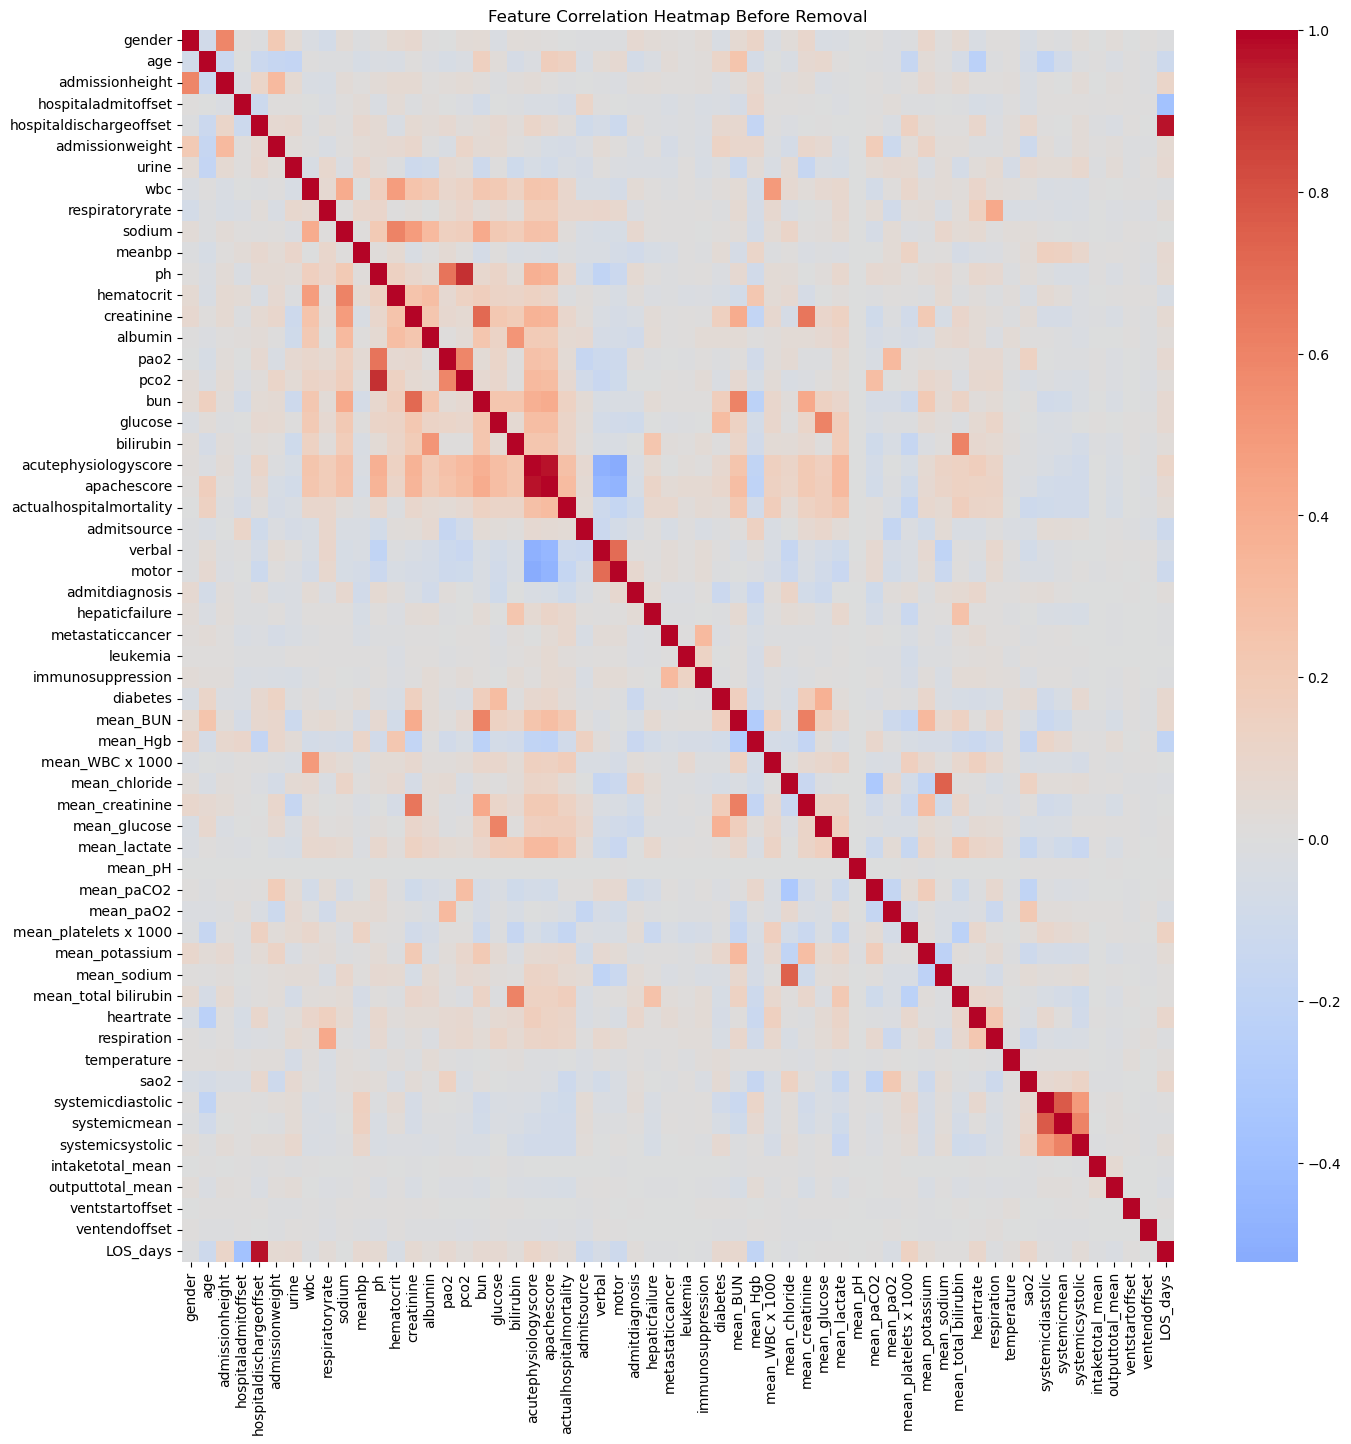

 Features with High Correlation (> 0.9):
                   Feature
0     acutephysiologyscore
1                 LOS_days
2              apachescore
3  hospitaldischargeoffset
4                     pco2
5                       ph


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

numeric_df = merged_df.select_dtypes(include=["number"])

print(" Computing correlation matrix...")
corr_matrix = numeric_df.corr()

high_corr_features = set()
threshold = 0.9

for col in corr_matrix.columns:
    for index in corr_matrix.index:
        if abs(corr_matrix.loc[col, index]) > threshold and col != index:
            high_corr_features.add(index)

plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap Before Removal")
plt.show()

high_corr_features_df = pd.DataFrame({"Feature": list(high_corr_features)})
print(" Features with High Correlation (> 0.9):")
print(high_corr_features_df)


In [8]:
correlation_pco2_ph = merged_df[["pco2", "ph"]].corr()
print(" Correlation between `pco2` and `ph`:")
print(correlation_pco2_ph)

 Correlation between `pco2` and `ph`:
          pco2        ph
pco2  1.000000  0.909135
ph    0.909135  1.000000


In [9]:
correlation_apache_aps = merged_df[["apachescore", "acutephysiologyscore"]].corr()
print(" Correlation between `apachescore` and `acutephysiologyscore`:")
print(correlation_apache_aps)

 Correlation between `apachescore` and `acutephysiologyscore`:
                      apachescore  acutephysiologyscore
apachescore              1.000000              0.970145
acutephysiologyscore     0.970145              1.000000


In [10]:
correlation_apache_aps = merged_df[["respiration", "respiratoryrate"]].corr()
print(" Correlation between `apachescore` and `acutephysiologyscore`:")
print(correlation_apache_aps)

 Correlation between `apachescore` and `acutephysiologyscore`:
                 respiration  respiratoryrate
respiration         1.000000         0.421502
respiratoryrate     0.421502         1.000000


In [11]:
correlation_apache_aps = merged_df[["hospitaldischargeoffset", "LOS_days"]].corr()
print(" Correlation between `hospitaldischargeoffset` and `LOS_days`:")
print(correlation_apache_aps)

 Correlation between `hospitaldischargeoffset` and `LOS_days`:
                         hospitaldischargeoffset  LOS_days
hospitaldischargeoffset                 1.000000  0.967081
LOS_days                                0.967081  1.000000


In [12]:
merged_df = merged_df.drop(columns=["hospitaldischargeoffset", "pco2"], errors="ignore")
print("Removed hospitaldischargeoffset and pco2 because of high correlation with LOS_days and ph")

Removed hospitaldischargeoffset and pco2 because of high correlation with LOS_days and ph


In [13]:
merged_df = merged_df.drop(columns=["apachescore","acutephysiologyscore"], errors="ignore")
print("Remoned apachescore and acutephysiologyscore as we dont have them in mimic dataset")

Remoned apachescore and acutephysiologyscore as we dont have them in mimic dataset


In [14]:
non_numeric_cols = merged_df.select_dtypes(include=["object"]).columns
print(f" Non-numeric columns: {list(non_numeric_cols)}")

 Non-numeric columns: []


In [15]:
merged_df.drop(columns=['ventstartoffset','ventendoffset'],axis=1,inplace=True)
print("Removed ventstartoffset and ventendoffset because of less significance because of LOS_days")

Removed ventstartoffset and ventendoffset because of less significance because of LOS_days


In [16]:
merged_df.columns

Index(['gender', 'age', 'admissionheight', 'hospitaladmitoffset',
       'admissionweight', 'urine', 'wbc', 'respiratoryrate', 'sodium',
       'meanbp', 'ph', 'hematocrit', 'creatinine', 'albumin', 'pao2', 'bun',
       'glucose', 'bilirubin', 'actualhospitalmortality', 'admitsource',
       'verbal', 'motor', 'admitdiagnosis', 'hepaticfailure',
       'metastaticcancer', 'leukemia', 'immunosuppression', 'diabetes',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'intaketotal_mean', 'outputtotal_mean', 'LOS_days'],
      dtype='object')

 Computing Mutual Information with Single-Core Processing...


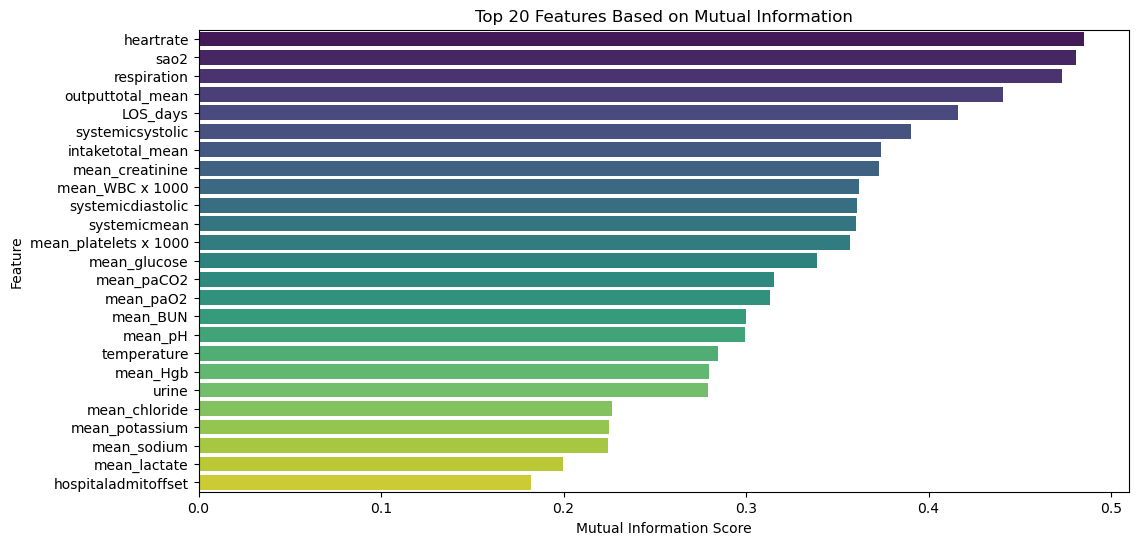

MI Computation Completed Using Single-Core Processing!


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

print(" Computing Mutual Information with Single-Core Processing...")

target = "actualhospitalmortality"
features = merged_df.drop(columns=[target])
target_values = merged_df[target]

X_np = features.to_numpy()
X_np = features.fillna(features.median()).to_numpy()
y_np = target_values.to_numpy()

mi_scores = mutual_info_classif(X_np, y_np, discrete_features="auto")

mi_scores_df = pd.DataFrame({"Feature": features.columns, "MI Score": mi_scores})
mi_scores_df = mi_scores_df.sort_values(by="MI Score", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y=mi_scores_df["Feature"][:25], x=mi_scores_df["MI Score"][:25], palette="viridis")
plt.title("Top 20 Features Based on Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.show()
print("MI Computation Completed Using Single-Core Processing!")

 Optimizing Random Forest Feature Importance Calculation...


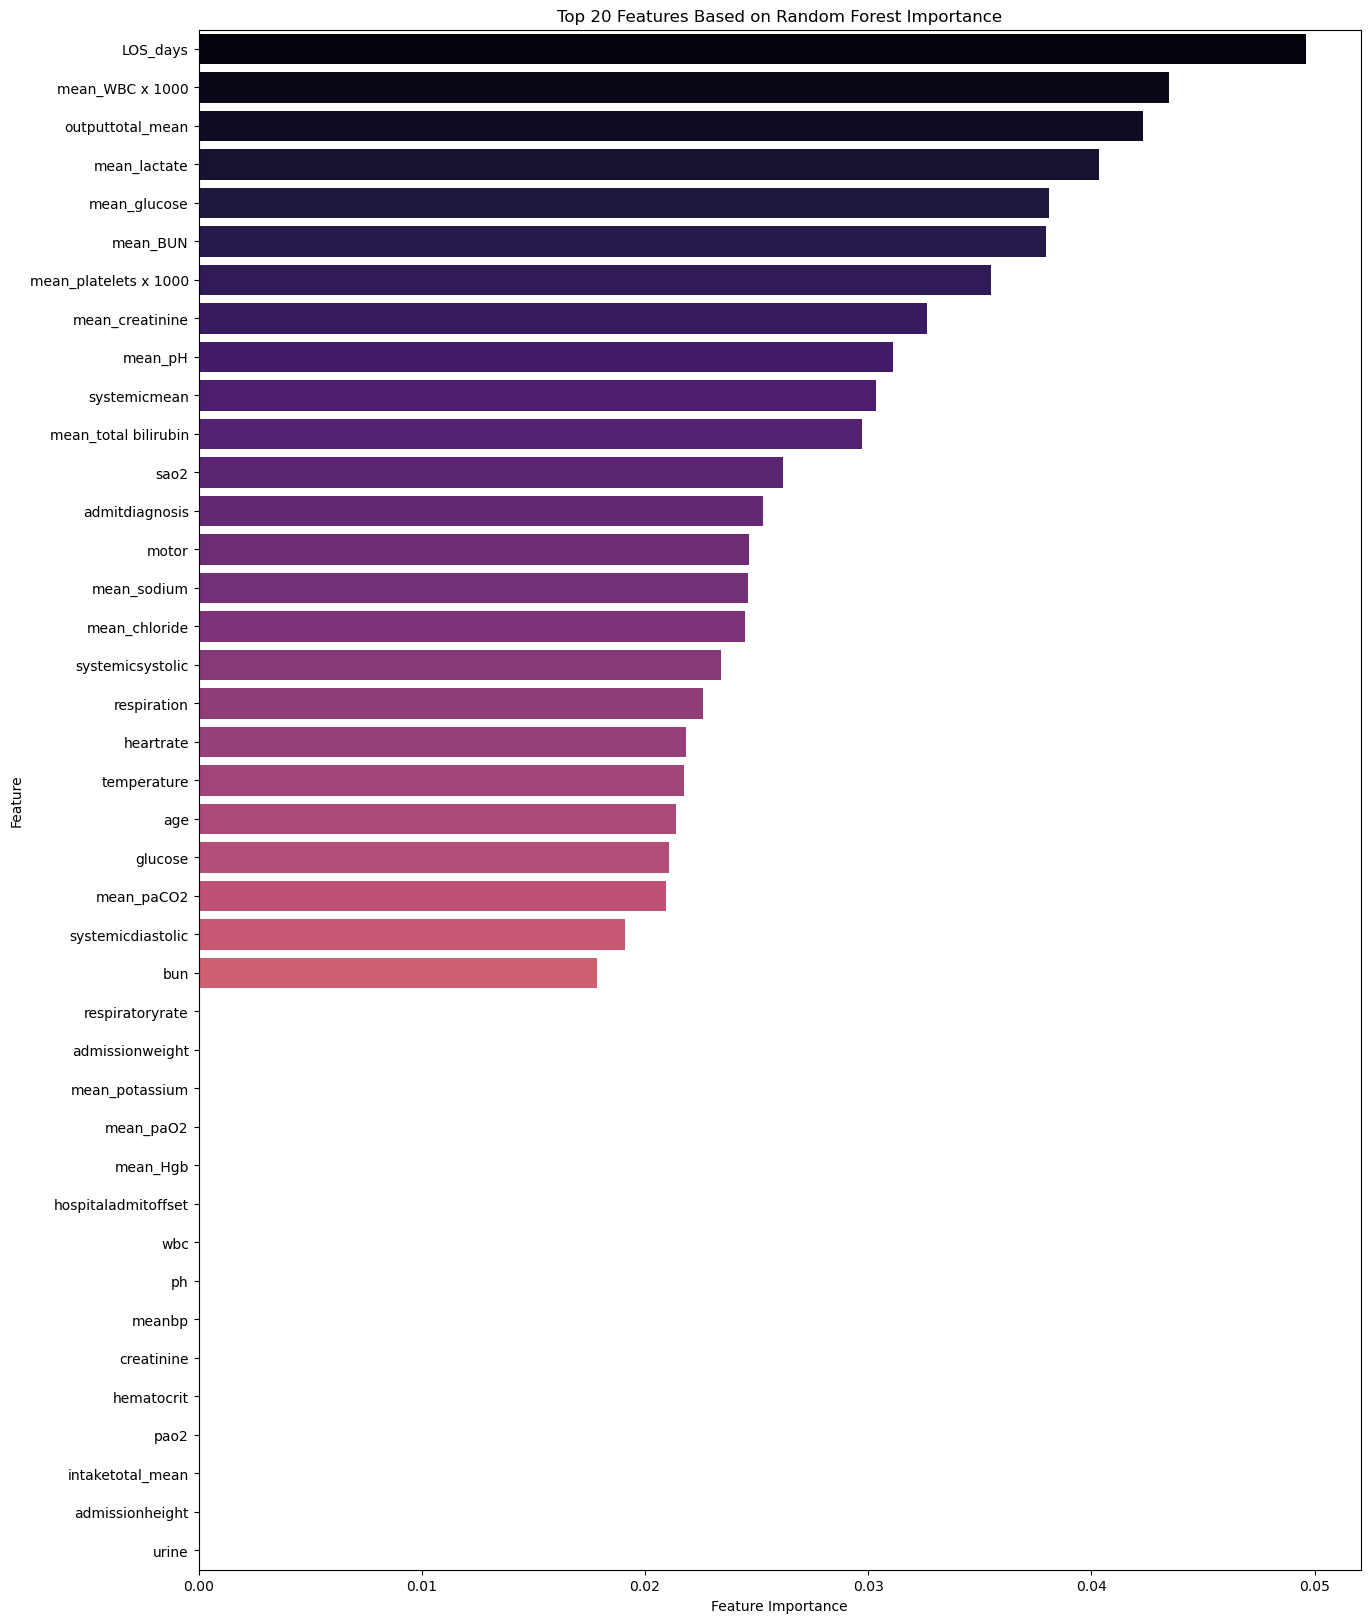

 Features with Low Importance (Importance < 0.01): 9 features found.
              Feature  Importance
19             verbal    0.007193
18        admitsource    0.006903
13            albumin    0.006756
23   metastaticcancer    0.002167
26           diabetes    0.001900
0              gender    0.001424
22     hepaticfailure    0.001067
25  immunosuppression    0.000975
24           leukemia    0.000508
 Features recommended for removal (9 total):
{'albumin', 'hepaticfailure', 'diabetes', 'gender', 'immunosuppression', 'leukemia', 'metastaticcancer', 'verbal', 'admitsource'}


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

print(" Optimizing Random Forest Feature Importance Calculation...")

target = "actualhospitalmortality"

features = merged_df.drop(columns=[target])
target_values = merged_df[target]

X = features.values
y = target_values.values

rf = RandomForestClassifier(n_estimators=60, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X, y)

feature_importances = pd.DataFrame({"Feature": features.columns, "Importance": rf.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(y=feature_importances["Feature"][:40], x=feature_importances["Importance"][:25], palette="magma")
plt.title("Top 20 Features Based on Random Forest Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

low_importance_features = feature_importances[feature_importances["Importance"] < 0.01]
print(f" Features with Low Importance (Importance < 0.01): {len(low_importance_features)} features found.")
print(low_importance_features)

features_to_remove =set(low_importance_features["Feature"])

print(f" Features recommended for removal ({len(features_to_remove)} total):")
print(features_to_remove)

In [19]:
features_to_remove = [
'immunosuppression', 'albumin', 'admitsource', 'verbal', 'diabetes', 'metastaticcancer',
 'leukemia', 'hepaticfailure', 'gender'
]

merged_df = merged_df.drop(columns=features_to_remove, errors="ignore")

print(" Removed low-importance features that are not essential.")
print(f" Updated dataset shape: {merged_df.shape}")
print(f" Remaining columns: {list(merged_df.columns)}")

 Removed low-importance features that are not essential.
 Updated dataset shape: (1908519, 43)
 Remaining columns: ['age', 'admissionheight', 'hospitaladmitoffset', 'admissionweight', 'urine', 'wbc', 'respiratoryrate', 'sodium', 'meanbp', 'ph', 'hematocrit', 'creatinine', 'pao2', 'bun', 'glucose', 'bilirubin', 'actualhospitalmortality', 'motor', 'admitdiagnosis', 'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride', 'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH', 'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium', 'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration', 'temperature', 'sao2', 'systemicdiastolic', 'systemicmean', 'systemicsystolic', 'intaketotal_mean', 'outputtotal_mean', 'LOS_days']


In [20]:
['age', 'admissionheight', 'hospitaladmitoffset', 'admissionweight', 'urine', 'wbc',
 'respiratoryrate', 'sodium', 'meanbp', 'ph', 'hematocrit', 'creatinine', 'pao2', 'bun', 
 'glucose', 'bilirubin', 'actualhospitalmortality', 'motor', 'admitdiagnosis', 'mean_BUN', 
 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride', 'mean_creatinine', 'mean_glucose', 'mean_lactate',
 'mean_pH', 'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium', 'mean_sodium', 
 'mean_total bilirubin', 'heartrate', 'respiration', 'temperature', 'sao2', 'systemicdiastolic', 
 'systemicmean', 'systemicsystolic', 'intaketotal_mean', 'outputtotal_mean', 'LOS_days']

['age',
 'admissionheight',
 'hospitaladmitoffset',
 'admissionweight',
 'urine',
 'wbc',
 'respiratoryrate',
 'sodium',
 'meanbp',
 'ph',
 'hematocrit',
 'creatinine',
 'pao2',
 'bun',
 'glucose',
 'bilirubin',
 'actualhospitalmortality',
 'motor',
 'admitdiagnosis',
 'mean_BUN',
 'mean_Hgb',
 'mean_WBC x 1000',
 'mean_chloride',
 'mean_creatinine',
 'mean_glucose',
 'mean_lactate',
 'mean_pH',
 'mean_paCO2',
 'mean_paO2',
 'mean_platelets x 1000',
 'mean_potassium',
 'mean_sodium',
 'mean_total bilirubin',
 'heartrate',
 'respiration',
 'temperature',
 'sao2',
 'systemicdiastolic',
 'systemicmean',
 'systemicsystolic',
 'intaketotal_mean',
 'outputtotal_mean',
 'LOS_days']

selected_features = ['age', 'admissionweight', 'respiratoryrate', 'ph', 'bun',
       'glucose', 'motor',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean', 'LOS_days']

In [21]:
merged_df.drop(columns=[
    'admissionheight',
    'hospitaladmitoffset',
    'urine',
    'wbc',
    'sodium',
    'meanbp',
    'hematocrit',
    'creatinine',
    'pao2',
    'bilirubin',
    'admitdiagnosis',
    'intaketotal_mean'
], errors="ignore",inplace=True)

In [22]:
merged_df.columns

Index(['age', 'admissionweight', 'respiratoryrate', 'ph', 'bun', 'glucose',
       'actualhospitalmortality', 'motor', 'mean_BUN', 'mean_Hgb',
       'mean_WBC x 1000', 'mean_chloride', 'mean_creatinine', 'mean_glucose',
       'mean_lactate', 'mean_pH', 'mean_paCO2', 'mean_paO2',
       'mean_platelets x 1000', 'mean_potassium', 'mean_sodium',
       'mean_total bilirubin', 'heartrate', 'respiration', 'temperature',
       'sao2', 'systemicdiastolic', 'systemicmean', 'systemicsystolic',
       'outputtotal_mean', 'LOS_days'],
      dtype='object')